In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from gwbench import Network, injections_CBC_params_redshift
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm

## Get injection data

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files', 'BBH', 
                             'LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
inj_data = dd.io.load(inj_data_file)

In [4]:
inj_data['Optimal_SNR'].keys()

Index(['PSD_L1', 'PSD_H1', 'PSD_I1', 'spin1_a', 'spin2_a', 'chi_eff', 'chi_p',
       'mchirp', 'srcmchirp', 'cos_spin1_polar', 'cos_spin2_polar', 'srcmass1',
       'srcmass2', 'q', 'spin1_azimuthal', 'spin2_azimuthal', 'redshift',
       'eta', 'spin1_polar', 'spin2_polar', 'mtotal', 'srcmtotal',
       'chi_1_in_plane', 'chi_2_in_plane', 'phi_12', 'phi_jl', 'theta_jn',
       'time_interval', 'inclination', 'distance', 'mass1', 'mass2',
       'coa_phase', 'f_ref', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
       'spin2z', 'approximant', 'f_lower', 'delta_f', 'f_final', 'dec',
       'trigger_time', 'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_I1',
       'SNR_network'],
      dtype='object')

In [5]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, method='network', return_detected_dict=False):
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        dict_key = key.split('SNR_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [6]:
inj_data['detected'] = get_detected_SNRs(inj_data['Optimal_SNR'], method='two-detector')

#### Choose n_events from detected as injection parameters

In [7]:
n_events = 500
inj_data['selected_n_events'] = inj_data['detected'].sample(n_events, random_state=123).sort_index()

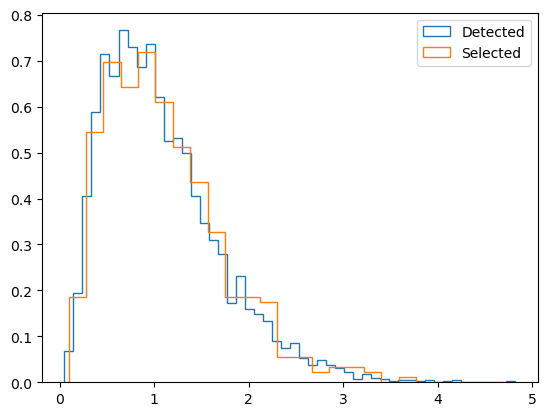

In [8]:
plt.hist(inj_data['detected']['redshift'], density=True, histtype=u'step', bins=50, label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', bins=20, label='Selected');
plt.legend()

## FM analysis with GWFish

### Setup

### Calculate Errors

### Add redshift to results file

In [45]:
i=0
for DL, z in zip(inj_data['selected_n_events']['distance'], inj_data['selected_n_events']['redshift']):
    if DL == failed_events['inj_params'][0]['DL']:
        print(f'Skipping event number {i}')
    else:
        results['inj_params'][i]['z'] = z
        i += 1

Skipping event number 331


Text(0.5, 0, '$\\Delta D_L / D_L$')

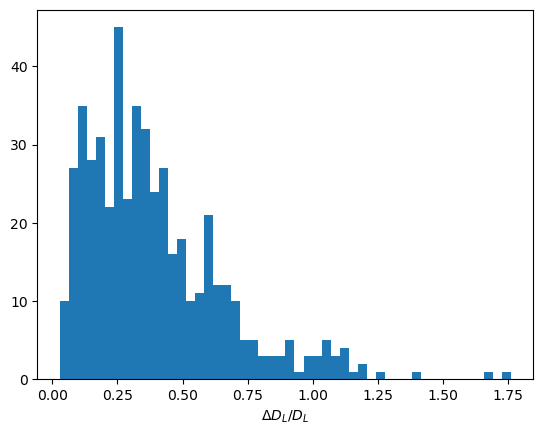

In [46]:
plt.hist([results['errs'][i]['log_DL'] for i in range(len(results['errs']))], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

## Save to h5 file

In [47]:
def save_results_to_h5(results, filename):
    with h5py.File(filename, 'w') as f:
        # Save inj_params
        inj_params_group = f.create_group('inj_params')
        for i, param_dict in enumerate(results['inj_params']):
            param_group = inj_params_group.create_group(str(i))
            for key, value in param_dict.items():
                param_group.create_dataset(key, data=value)

        # Save cov (numpy matrices)
        cov_group = f.create_group('cov')
        for i, matrix in enumerate(results['cov']):
            cov_group.create_dataset(str(i), data=matrix)

        # Save errs
        errs_group = f.create_group('errs')
        for i, err_dict in enumerate(results['errs']):
            err_group = errs_group.create_group(str(i))
            for key, value in err_dict.items():
                err_group.create_dataset(key, data=value)

        # Save deriv_variables_in_order (list of strings)
        dt = h5py.string_dtype(encoding='utf-8')
        f.create_dataset('deriv_variables_in_order', 
                         data=np.array(results['deriv_variables_in_order'], 
                                       dtype=dt))

In [48]:
results_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH',
                            'LHI_Asharp_PLP_z_MD_zmax_6_lmrd_22.h5')
save_results_to_h5(results, results_file)

## Spot checks with MPSAC study

In [130]:
mpsac_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/Relevant_papers/Ish Gupta_et_al_data/'
mpsac_data_bbh = {}
with h5py.File(glob(os.path.join(mpsac_dir, '*', '*', '*bbh*hdf5'))[0], 'r') as file:
    i=100
    inj_params = {key:file['inj_params'][key][i] for key in file['inj_params'].keys()}
    Mc = (1+inj_params['z'])*inj_params['Mc']
    inj_params['Mc'] = Mc
    print(inj_params)
    fm, cov, errs = run_analysis(inj_params)
    err_dict = {key:[file['networks']['HLI'][key][i], errs[key]] for key in errs.keys()}
    err_dict['source'] = ['MPSAC', 'Current analysis']
    err_df = pd.DataFrame(err_dict).set_index('source').T

2025-04-28 17:14:13,053 - Network - INFO : PSDs, antenna patterns, and LPFs loaded.
2025-04-28 17:14:13,055 - Network - INFO : Calculate numeric derivatives of detector responses.
2025-04-28 17:14:13,057 - Network - INFO :    A-Sharp_L


{'DL': np.float64(1201.7289284158655), 'Mc': np.float64(10.173076975377805), 'chi1x': np.float64(0.0), 'chi1y': np.float64(0.0), 'chi1z': np.float64(0.19211394154826045), 'chi2x': np.float64(0.0), 'chi2y': np.float64(0.0), 'chi2z': np.float64(0.6754359033651994), 'dec': np.float64(0.8868455246623403), 'eta': np.float64(0.24979572202585482), 'gmst0': np.float64(44958.217426017385), 'iota': np.float64(1.794815369700618), 'log_DL': np.float64(7.091516572537438), 'log_Mc': np.float64(2.110255321424193), 'phic': np.float64(0.0), 'psi': np.float64(6.015544099346893), 'ra': np.float64(4.986160332486727), 'tc': np.float64(0.0), 'z': np.float64(0.23304830102271445)}


2025-04-28 17:14:14,638 - Network - INFO :    A-Sharp_H
2025-04-28 17:14:16,266 - Network - INFO :    A-Sharp_I
2025-04-28 17:14:17,822 - Network - INFO : Numeric derivatives of detector responses calculated.
2025-04-28 17:14:17,824 - Network - INFO : SNRs calculated.
2025-04-28 17:14:17,825 - Network - INFO : Calculate errors (Fisher & cov matrices).
2025-04-28 17:14:17,826 - Network - INFO :    A-Sharp_L
2025-04-28 17:14:17,884 - Network - INFO :    A-Sharp_H
2025-04-28 17:14:17,934 - Network - INFO :    A-Sharp_I
2025-04-28 17:14:17,997 - Network - INFO : Sky areas calculated.
2025-04-28 17:14:17,998 - Network - INFO : Errors calculated.


In [131]:
err_df

source,MPSAC,Current analysis
log_Mc,0.000212,0.000261
eta,0.000101,0.000238
log_DL,0.109427,0.347435
iota,0.067809,0.235479
tc,0.000230,0.000257
phic,1.234825,1.137982
ra,0.014507,0.018048
dec,0.036084,0.034405
psi,0.095636,0.229906
chi1z,0.003444,0.006480
